# Globeloc

The core functionality to create the data structure for the global spatial array.

There are four parts

1. The creation of data in the array format
2. The storage of data in a flat file format
3. The loading and access to the data as per pandas api
4. A cloud hosted data store where uses can push, pull, add data

The specification for this product is layed out in the product description document

In [1]:
import fiona
import pandas as pd
import geopandas as gpd

In [2]:
f_df = gpd.read_file("./gis_osm_pois_free_1.shp")

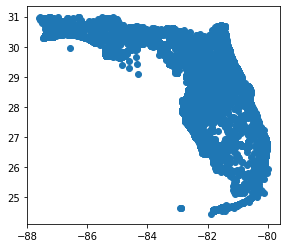

In [3]:
f_df.plot()

In [4]:
f_df.describe()

,code
count,47385.000000
mean,2480.199304
std,306.285068
min,2001.000000
25%,2301.000000
50%,2424.000000
75%,2741.000000
max,2964.000000


OK so we have 72K locations of interest... But what we want is to able to search the data. Traditionally we would need to define a polygon boundary and then write a intersection query. If we want this to be fast it means we have to make a quadtree. Or use a database.

But what if we could just index into the world and pick the data we wanted?

Or we could just multiply arrays. The boundary we want x the base data set.

# Create the raw data

In [5]:
import numpy as np
from scipy import sparse

We need to know the size of our array.

Number of files, rows, cols.

In [6]:
num_deci_places = 10000 # https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude
n_depth = len(set(f_df.fclass))
col_keys = [k for k in set(f_df.fclass)]
n_rows = 180 * num_deci_places
n_cols = 360 * num_deci_places
n_files = None
col_keys

['bench',
 'park',
 'mall',
 'car_sharing',
 'bar',
 'ice_rink',
 'waste_basket',
 'pub',
 'ruins',
 'recycling_metal',
 'wayside_cross',
 'post_office',
 'car_wash',
 'lighthouse',
 'chalet',
 'stadium',
 'water_tower',
 'dog_park',
 'florist',
 'video_shop',
 'atm',
 'water_well',
 'nursing_home',
 'kindergarten',
 'pharmacy',
 'gift_shop',
 'recycling_paper',
 'library',
 'recycling',
 'hostel',
 'hotel',
 'zoo',
 'recycling_clothes',
 'computer_shop',
 'bookshop',
 'memorial',
 'vending_cigarette',
 'doctors',
 'playground',
 'shelter',
 'garden_centre',
 'jeweller',
 'hunting_stand',
 'beverages',
 'telephone',
 'convenience',
 'windmill',
 'hospital',
 'mobile_phone_shop',
 'food_court',
 'castle',
 'butcher',
 'swimming_pool',
 'camp_site',
 'public_building',
 'doityourself',
 'car_rental',
 'golf_course',
 'school',
 'tower',
 'vending_parking',
 'archaeological',
 'prison',
 'cafe',
 'greengrocer',
 'fire_station',
 'water_works',
 'picnic_site',
 'observation_tower',
 'waste

In [7]:
coords = f_df.geometry
f_df['x'] = coords.apply(lambda p: p.x) # Lon
f_df['y'] = coords.apply(lambda p: p.y) # Lat

In [8]:
f_df['t_x'] = f_df['x'].apply(lambda p: round((p + 180) * num_deci_places), 0)
f_df['t_y'] = f_df['y'].apply(lambda p: round((p + 90) * num_deci_places), 0)

In [9]:
# assuming we always have less data than then number of cells
arrays = [sparse.lil_matrix((n_rows, n_cols), dtype=np.uint8) for _ in range(1)] #n_depth limit to one thing]
start_of_slices = f_df['t_x'].min()
for ix, row in f_df.iterrows():
    what = row.fclass
    what_index = col_keys.index(what)
    arrays[0][row.t_y, row.t_x - start_of_slices] += 1

In [10]:
for k, attribute in enumerate(arrays):
    hit_count = attribute.sum()
    print(f'Found {hit_count} value/s')
    what_thing = col_keys[k]
    sparse.save_npz(f'./data/{what_thing}.npz',attribute.tocsr())

Found 47385 value/s


Interestingly we can use "cupy" directly to load these arrays into GPU and compute on the > 4x faster

https://docs-cupy.chainer.org/en/stable/reference/sparse.html

Now we want to find a boundary and query it against this array.

Lets look at Miami!


In [95]:
miami_df = gpd.read_file("./MiamiDadeBoundary.shp")
miami_a = sparse.lil_matrix((n_rows, n_cols))
miami_df = miami_df.to_crs('epsg:4326')

/home/plantz/anaconda3/envs/gloc/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [96]:
e_line = [(round((c[0] + 180) * num_deci_places), round((c[1] + 90) * num_deci_places)) for c in miami_df.geometry[0].exterior.coords[:]]
lines = [(e_line[i], e_line[i + 1]) for i in range(len(e_line) - 1)]

In [97]:
from skimage.draw import line_nd

In [98]:
for l in lines:
    miami_a[line_nd(l[0], l[-1])] = 1

In [105]:
from scipy.ndimage.morphology import binary_fill_holes

In [120]:
binary_fill_holes(miami_a).astype(int)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

In [121]:
from skimage.segmentation import flood, flood_fill

In [122]:
flood_fill(miami_a, e_line[0], 1, tolerance=10)

IndexError: too many indices for array